# **Transformer from Scratch!**
## (Build a language model to translate English to Hindi)

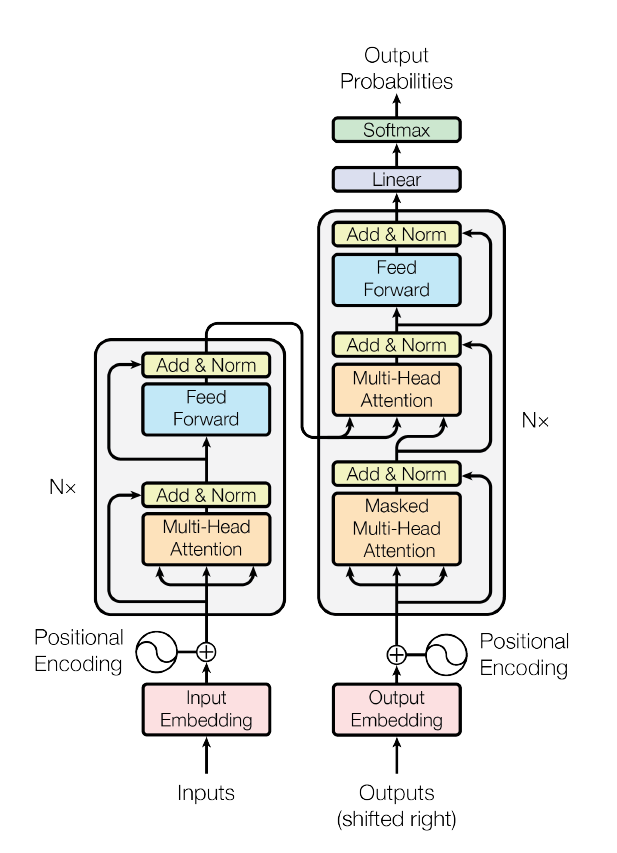

# 1. Data Preparation and Preprocessing




Here we will use the [IIT Bombay English-Hindi corpus contains parallel corpus](https://www.cfilt.iitb.ac.in/iitb_parallel/).

---



In [ ]:
! pip install subword-nmt # We require this for 'tokenisation' later on

In [ ]:
!pip install datasets==1.18.1 # This is needed to load the dataset


In [ ]:
import numpy as np
from datasets import load_dataset
import time

# Load the dataset
print("Loading dataset...")


In [ ]:
dataset = load_dataset("cfilt/iitb-english-hindi")
dataset

## 1.1 Loading and Splitting the Dataset
First, we'll load our dataset and into training, validation, and test sets. The dataset is already split by the dataset creators, we will use their same split.

In [ ]:
# Open files for writing source and target sentences for the training set
source_train_file = open("source_train.txt", "w+", encoding='utf8')
target_train_file = open("target_train.txt", "w+", encoding='utf8')

# Write sentences to the training files
for translation_pair in dataset["train"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  source_train_file.write(source_sentence.strip("\n") + "\n")
  target_train_file.write(target_sentence.strip("\n") + "\n")

# Close the training files
source_train_file.close()
target_train_file.close()


# Repeat the process for validation set
source_valid_file = open("source_valid.txt", "w+", encoding='utf8')
target_valid_file = open("target_valid.txt", "w+", encoding='utf8')
for translation_pair in dataset["validation"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  source_valid_file.write(source_sentence.strip("\n") + "\n")
  target_valid_file.write(target_sentence.strip("\n") + "\n")
source_valid_file.close()
target_valid_file.close()

# Repeat the process for test set
source_test_file = open("source_test.txt", "w+", encoding='utf8')
target_test_file = open("target_test.txt", "w+", encoding='utf8')
for translation_pair in dataset["test"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  source_test_file.write(source_sentence.strip("\n") + "\n")
  target_test_file.write(target_sentence.strip("\n") + "\n")
source_test_file.close()
target_test_file.close()

## 1.2 Checking Dataset Size
After creating our dataset files, it's important to verify the size of each set:

In [ ]:
! wc -l source_train.txt target_train.txt source_valid.txt target_valid.txt source_test.txt target_test.txt


We see that there is less data for validation, we can create a split later.

## 1.3 Applying Byte Pair Encoding (BPE)


Next, we'll apply Byte Pair Encoding to our dataset. BPE is a data compression technique that iteratively replaces the most frequent pair of bytes in a sequence with a single, unused byte. In NLP, it's used for subword tokenization.

In [ ]:
import os
os.environ['NUM_OF_MERGE_OPERATIONS'] = "16000"

In [ ]:
! cat source_train.txt source_test.txt source_valid.txt > source_full.txt
! cat target_train.txt target_test.txt target_valid.txt > target_full.txt

In [ ]:
! subword-nmt learn-bpe -s $NUM_OF_MERGE_OPERATIONS < source_full.txt > source-bpe.codes
! subword-nmt learn-bpe -s $NUM_OF_MERGE_OPERATIONS < target_full.txt > target-bpe.codes

In [ ]:
! subword-nmt apply-bpe -c source-bpe.codes < source_train.txt > source_train_bpe.txt
! subword-nmt apply-bpe -c source-bpe.codes < source_valid.txt > source_valid_bpe.txt
! subword-nmt apply-bpe -c source-bpe.codes < source_test.txt > source_test_bpe.txt

! subword-nmt apply-bpe -c target-bpe.codes < target_train.txt > target_train_bpe.txt
! subword-nmt apply-bpe -c target-bpe.codes < target_valid.txt > target_valid_bpe.txt
! subword-nmt apply-bpe -c target-bpe.codes < target_test.txt > target_test_bpe.txt

This process helps us handle out-of-vocabulary words and reduces the vocabulary size, making our model more efficient.

In [ ]:
! wc -l source-bpe.codes target-bpe.codes


In [ ]:
! wc -l source_train_bpe.txt target_train_bpe.txt source_valid_bpe.txt target_valid_bpe.txt source_test_bpe.txt target_test_bpe.txt

# 2. Building the Vocabulary
After preprocessing our data with Byte Pair Encoding, the next crucial step is to build our vocabulary. This vocabulary will be used to convert words into indices that our model can process.

## 2.1 Defining the Vocabulary Building Function
We'll start by defining a function to build our vocabulary:

In [ ]:
from collections import Counter

def build_vocab(filename, min_freq=2):
    counter = Counter()
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            counter.update(line.strip().split())
    
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    
    # Add words with index starting at 4
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab   # <-- REQUIRED
    
# Build vocabularies
src_vocab = build_vocab('source_train_bpe.txt')
tgt_vocab = build_vocab('target_train_bpe.txt')

print(f"Source vocabulary size: {len(src_vocab)}")
print(f"Target vocabulary size: {len(tgt_vocab)}")

# Verify special tokens
special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
for token in special_tokens:
    if token not in src_vocab or token not in tgt_vocab:
        raise ValueError(f"Special token {token} is missing from vocabulary.")

print("Vocabularies created and verified successfully.")


# 3. Data Encoding and Preparation
After building our vocabulary, the next step is to encode our sentences and prepare them for input into our Transformer model. This process involves converting words to indices, padding sequences, and creating data loaders.

## 3.1 Encoding and Padding Functions
First, let's look at the functions for encoding sentences and padding sequences:

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, random_split
import random

def encode_sentence(vocab, sentence):
    tokens = sentence.strip().split()
    return [vocab.get(token, vocab['<unk>']) for token in tokens] #<unk> accounts for unknown tokens

def load_and_encode(filename, vocab, indices):
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    subset_lines = [lines[i] for i in indices]
    encoded_lines = [encode_sentence(vocab, line) for line in subset_lines]

    #Filter out tokens that are not in the vocabulary
    filtered_lines = []
    for line in encoded_lines:
        filtered_line = [token for token in line if token < len(vocab)]
        filtered_lines.append(filtered_line)
    return filtered_lines

def pad_sequences(sequences, pad_idx, max_len):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [pad_idx] * (max_len - len(seq))
        padded_sequences.append(torch.tensor(seq))
    return torch.stack(padded_sequences)



These functions do the following:
* encode_sentence: Converts a sentence into a list of vocabulary indices.
* load_and_encode: Loads sentences from a file and encodes them.
* pad_sequences: Pads shorter sequences with a padding token to ensure all sequences have the same length.

## 3.2 Creating DataLoader
Data loaders are essential for efficiently managing and feeding data to the model during the training and validation phases.

Next, we define a function to create our DataLoader:

In [ ]:
def create_dataloader(src_encoded, tgt_encoded, batch_size=16, val_split=0.1):
    dataset = TensorDataset(src_encoded, tgt_encoded)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

This function creates a TensorDataset from our encoded source and target sentences and then creates a DataLoader object.

## 3.3 Preparing the Data
In this step, we prepare our data by loading, encoding, and selecting a subset of our training data:

In [ ]:
# Use 10% of the dataset
subset_ratio = 0.1
with open('source_train_bpe.txt', 'r', encoding='utf-8') as f:
    total_lines = f.readlines()
subset_size = int(len(total_lines) * subset_ratio)
subset_indices = random.sample(range(len(total_lines)), subset_size)

#This line calls the load_and_encode function to load and encode the selected subset of the source file using the src_vocab (or tgt_vocab) vocabulary.
src_encoded = load_and_encode('source_train_bpe.txt', src_vocab, subset_indices)
tgt_encoded = load_and_encode('target_train_bpe.txt', tgt_vocab, subset_indices)

# Ensure the lengths match
print(f"Source encoded length: {len(src_encoded)}")
print(f"Target encoded length: {len(tgt_encoded)}")
assert len(src_encoded) == len(tgt_encoded), "Source and target lengths do not match."

## 3.4 Padding Sequences
After encoding our subset of data, we need to ensure that all sequences have the same length for batch processing. This is done through padding:

In [ ]:
# Determine the maximum length across both datasets
max_len = max(max(len(seq) for seq in src_encoded), max(len(seq) for seq in tgt_encoded))
print(f"Maximum sequence length: {max_len}")

# Pad sequences to the same maximum length
src_padded = pad_sequences(src_encoded, src_vocab['<pad>'], max_len)
tgt_padded = pad_sequences(tgt_encoded, tgt_vocab['<pad>'], max_len)

# Ensure the padded sequences have the same number of samples
print(f"Source padded shape: {src_padded.shape}")
print(f"Target padded shape: {tgt_padded.shape}")
assert src_padded.size(0) == tgt_padded.size(0), "Padded source and target sizes do not match."

## 3.5 Creating DataLoaders
After padding our sequences, the final step is to create DataLoaders for our training and validation sets

In [ ]:
# Create DataLoader for training and validation datasets
train_dataloader, val_dataloader = create_dataloader(src_padded, tgt_padded)

# 4. Positional Encoding
Positional Encoding is a crucial component of the Transformer architecture. It adds information about the position of tokens in the sequence, which is necessary because the Transformer doesn't inherently have a way to understand the order of inputs.

https://youtu.be/7CNElr-TAQw?si=gzGg-LUrUWVN9u0T


In [ ]:
import torch.nn as nn
import numpy as np

#PositionalEncoding is defined as a subclass of nn.Module, making it a layer in our neural network.

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000): #d_model: The dimensionality of the model's embeddings, max_len: The maximum sequence length (default 5000).
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model) # Creates a matrix of shape (max_len, d_model) filled with zeros.
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term) # Even positions
        pe[:, 1::2] = torch.cos(position * div_term) # Odd positions

        # Add a batch dimension and transpose to match input shape
        pe = pe.unsqueeze(0).transpose(0, 1)

        # Register the positional encoding tensor as a buffer (is not learned)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# Instantiate and print the positional encoding
d_model = 256 # Taking 256 instead of 512
pos_encoding = PositionalEncoding(d_model)
print(pos_encoding.pe)


The output of print(pos_encoding.pe) will show a matrix of shape (1, 5000, 256), where each row represents the positional encoding for a position in the sequence, and each column represents a dimension of the encoding.


# 5. Scaled Dot-Product Attention

## 5.1 Function Definition


In [ ]:
import math

def scaled_dot_product_attention(query, key, value, mask=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e4)  # Using -10,000 here, we just need a small enough number.
    attn = torch.nn.functional.softmax(scores, dim=-1)
    output = torch.matmul(attn, value)
    return output, attn

# Test scaled dot-product attention
query = torch.rand(16, 4, 256)
key = torch.rand(16, 4, 256)
value = torch.rand(16, 4, 256)
output, attn = scaled_dot_product_attention(query, key, value)
print(output)
print(attn)


# 6. Multi-Head Attention
The Multi-Head Attention mechanism is a key component of the Transformer architecture. It allows the model to jointly attend to information from different representation subspaces at different positions.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads # Calculates the dimension of each head.
        self.num_heads = num_heads
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)]) #Creates three linear transformations for query, key, and value.
        self.output_linear = nn.Linear(d_model, d_model) # Creates a final linear transformation for the output.
        self.attention = None

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query, key, value = [l(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]
        x, self.attention = scaled_dot_product_attention(query, key, value, mask=mask)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k) # This combines the num_heads and d_k dimensions back into a single dimension.
        return self.output_linear(x)

# Test multi-head attention
mha = MultiHeadAttention(d_model, 4)
query = torch.rand(16, 10, 256)
key = torch.rand(16, 10, 256)
value = torch.rand(16, 10, 256)
output = mha(query, key, value)
print(output)


# 7. Position-wise Feed-Forward Network
The Position-wise Feed-Forward Network is a crucial component in each layer of the Transformer. It's applied to each position separately and identically, which is why it's sometimes called "position-wise."

The FFN allows the model to process the attended information from the Multi-Head Attention layer.
The expansion to a larger inner-layer (d_ff) and then back to d_model allows for more complex transformations of the data.
ReLU introduces non-linearity, enabling the network to learn more complex functions.
This layer is applied identically to every position in the sequence, maintaining the model's ability to process variable-length sequences.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(torch.nn.functional.relu(self.linear1(x)))

# Test feed forward network
ffn = FeedForward(d_model)
x = torch.rand(16, 10, 256)
output = ffn(x)
print(output)


# 8. Encoder Layer
The Encoder Layer is a fundamental building block of the Transformer's encoder. It combines Multi-Head Attention and a Feed-Forward Network, along with layer normalization and residual connections.

### Without Checkpointing:
* All intermediate activations are stored during the forward pass.
* These activations are used during the backward pass to compute gradients.
* This can lead to high memory usage, limiting the model size or batch size.

### With Checkpointing:
* Only a subset of activations is stored during the forward pass.
* During the backward pass, some activations are recomputed as needed.
* This reduces memory usage, allowing for training larger models or using larger batch sizes.

In [ ]:
import torch.utils.checkpoint as checkpoint

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.sublayer = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(2)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x.requires_grad_(True)
        x = x + self.dropout(checkpoint.checkpoint(self.self_attn, self.sublayer[0](x), self.sublayer[0](x), self.sublayer[0](x), mask, use_reentrant=False))
        return x + self.dropout(checkpoint.checkpoint(self.feed_forward, self.sublayer[1](x), use_reentrant=False))
        # The input x is added to the output of the sub-layer (self-attention or feed-forward). This addition operation (x + ...) is the residual connection.

# Test encoder layer
encoder_layer = EncoderLayer(d_model, 4)
x = torch.rand(16, 10, 256)
output = encoder_layer(x)
print(output)


# 9. Transformer Encoder
The Encoder class creates the complete encoder part of the Transformer, consisting of multiple EncoderLayers stacked on top of each other.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff=2048, dropout=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# 10. Decoder Layer
The Decoder Layer is similar to the Encoder Layer but includes an additional Multi-Head Attention layer for attending to the encoder's output.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.sublayer = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(3)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask, tgt_mask):
        x = x + self.dropout(checkpoint.checkpoint(self.self_attn, self.sublayer[0](x), self.sublayer[0](x), self.sublayer[0](x), tgt_mask))
        x = x + self.dropout(checkpoint.checkpoint(self.cross_attn, self.sublayer[1](x), memory, memory, src_mask))
        return x + self.dropout(checkpoint.checkpoint(self.feed_forward, self.sublayer[2](x)))

# 11. Decoder
The Decoder consists of multiple DecoderLayers stacked on top of each other. It processes the target sequence and attends to the encoder's output.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff=2048, dropout=0.1):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

# 12. Transformer
The Transformer model combines the Encoder and Decoder. It uses embeddings and positional encodings for both source and target sequences.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, input_dim, output_dim, d_ff=2048, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(d_model, num_heads, num_layers, d_ff, dropout)
        self.decoder = Decoder(d_model, num_heads, num_layers, d_ff, dropout)
        self.src_embed = nn.Embedding(input_dim, d_model)
        self.tgt_embed = nn.Embedding(output_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.linear = nn.Linear(d_model, output_dim)

    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.src_embed(src) * math.sqrt(d_model)
        src = self.pos_encoder(src)
        tgt = self.tgt_embed(tgt) * math.sqrt(d_model)
        tgt = self.pos_encoder(tgt)

        memory = checkpoint.checkpoint(self.encoder, src, src_mask)
        output = checkpoint.checkpoint(self.decoder, tgt, memory, src_mask, tgt_mask)
        return self.linear(output)

def create_mask(src, tgt, pad_idx):
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(src.device)
    tgt_mask = tgt_mask & nopeak_mask
    return src_mask, tgt_mask

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                           ys,
                           subsequent_mask(ys.size(1)).type_as(src.data))
        prob = model.linear(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

# Instantiate the model
input_dim = len(src_vocab)
output_dim = len(tgt_vocab)
print(f"Input vocabulary size: {input_dim}")
print(f"Output vocabulary size: {output_dim}")
model = Transformer(d_model=256, num_heads=4, num_layers=6, input_dim=input_dim, output_dim=output_dim)
print(model)

# 13. Training
Training the Transformer involves defining the loss function, optimizer, and training loop. We use CrossEntropyLoss and Adam optimizer.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import os
from google.colab import drive
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
import torch.utils.checkpoint as checkpoint
import math

# Mount Google Drive
drive.mount('/content/drive')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
d_model = 256
num_heads = 4
num_layers = 6
batch_size = 16
accumulation_steps = 4
num_epochs = 5

# Instantiate the model (using the new Transformer class)
input_dim = len(src_vocab)
output_dim = len(tgt_vocab)
model = Transformer(d_model=d_model, num_heads=num_heads, num_layers=num_layers, input_dim=input_dim, output_dim=output_dim)
model.to(device)

# Initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Embedding):
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# Directory to save checkpoints
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# TensorBoard writer
writer = SummaryWriter()

# Create DataLoader for training and validation datasets
train_dataloader, val_dataloader = create_dataloader(src_padded, tgt_padded, batch_size=batch_size)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Training loop
best_loss = float('inf')
patience = 2
patience_counter = 0

pad_idx = src_vocab['<pad>']

for epoch in range(num_epochs):
    torch.cuda.empty_cache()  # Clear CUDA cache
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    optimizer.zero_grad()

    for i, (batch_src, batch_tgt) in enumerate(progress_bar):
        batch_src, batch_tgt = batch_src.to(device), batch_tgt.to(device)

        src_mask, tgt_mask = create_mask(batch_src, batch_tgt[:, :-1], pad_idx)

        with autocast():
            output = model(batch_src, batch_tgt[:, :-1], src_mask, tgt_mask)
            output = output.contiguous().view(-1, output_dim)
            tgt_output = batch_tgt[:, 1:].contiguous().view(-1)
            loss = criterion(output, tgt_output) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        average_loss = total_loss / (i + 1)
        progress_bar.set_postfix(loss=average_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader)}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch_src, val_batch_tgt in val_dataloader:
            val_batch_src, val_batch_tgt = val_batch_src.to(device), val_batch_tgt.to(device)
            src_mask, tgt_mask = create_mask(val_batch_src, val_batch_tgt[:, :-1], pad_idx)
            with autocast():
                val_output = model(val_batch_src, val_batch_tgt[:, :-1], src_mask, tgt_mask)
                val_output = val_output.contiguous().view(-1, output_dim)
                val_tgt_output = val_batch_tgt[:, 1:].contiguous().view(-1)
                val_loss += criterion(val_output, val_tgt_output).item()
    val_loss /= len(val_dataloader)
    print(f'Validation Loss: {val_loss}')

    # Early stopping and model saving logic
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    scheduler.step(val_loss)
    writer.add_scalar('Loss/train', total_loss/len(train_dataloader), epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

writer.close()

# Save final model
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)
print(f'Final model saved at {final_model_path}')

drive_model_path = '/content/drive/MyDrive/final_model.pth'
torch.save(model.state_dict(), drive_model_path)
print(f'Final model also saved to Google Drive at {drive_model_path}')

# 14. Inference
During inference, we use the trained model to generate translations.

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load BPE codes for source and target languages
from subword_nmt.apply_bpe import BPE

with open('source-bpe.codes', 'r', encoding='utf-8') as f:
    src_bpe = BPE(f)

with open('target-bpe.codes', 'r', encoding='utf-8') as f:
    tgt_bpe = BPE(f)

# Define the necessary components here
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

def scaled_dot_product_attention(query, key, value, mask=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e4)
    attn = torch.nn.functional.softmax(scores, dim=-1)
    output = torch.matmul(attn, value)
    return output, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = None

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query, key, value = [l(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]
        x, self.attention = scaled_dot_product_attention(query, key, value, mask=mask)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.output_linear(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(torch.nn.functional.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.sublayer = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(2)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.self_attn(self.sublayer[0](x), self.sublayer[0](x), self.sublayer[0](x), mask))
        return x + self.dropout(self.feed_forward(self.sublayer[1](x)))

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff=2048, dropout=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.sublayer = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(3)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask, tgt_mask):
        x = x + self.dropout(self.self_attn(self.sublayer[0](x), self.sublayer[0](x), self.sublayer[0](x), tgt_mask))
        x = x + self.dropout(self.cross_attn(self.sublayer[1](x), memory, memory, src_mask))
        return x + self.dropout(self.feed_forward(self.sublayer[2](x)))

class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff=2048, dropout=0.1):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, input_dim, output_dim, d_ff=2048, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(d_model, num_heads, num_layers, d_ff, dropout)
        self.decoder = Decoder(d_model, num_heads, num_layers, d_ff, dropout)
        self.src_embed = nn.Embedding(input_dim, d_model)
        self.tgt_embed = nn.Embedding(output_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.linear = nn.Linear(d_model, output_dim)

    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.src_embed(src) * math.sqrt(d_model)
        src = self.pos_encoder(src)
        tgt = self.tgt_embed(tgt) * math.sqrt(d_model)
        tgt = self.pos_encoder(tgt)

        memory = self.encoder(src, src_mask)
        output = self.decoder(tgt, memory, src_mask, tgt_mask)
        return self.linear(output)

def create_mask(src, tgt, pad_idx):
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(src.device)
    tgt_mask = tgt_mask & nopeak_mask
    return src_mask, tgt_mask

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encoder(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        tgt_mask = (ys != src_vocab['<pad>']).unsqueeze(1).unsqueeze(3) & subsequent_mask(ys.size(1)).type_as(src.data)
        out = model.decoder(model.pos_encoder(model.tgt_embed(ys) * math.sqrt(d_model)), memory, src_mask, tgt_mask)
        prob = model.linear(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == tgt_vocab['<eos>']:
            break
    return ys

def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

# Load the saved model from Google Drive
drive_model_path = '/content/drive/MyDrive/final_model.pth'
model = Transformer(d_model=256, num_heads=4, num_layers=6, input_dim=len(src_vocab), output_dim=len(tgt_vocab))

# Load state dictionary
state_dict = torch.load(drive_model_path, map_location=torch.device('cpu'))

# Filter out unexpected keys
model_state_dict = model.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
model_state_dict.update(filtered_state_dict)
model.load_state_dict(model_state_dict)

model.eval()

# Define a function to translate a given sentence
def translate_sentence(sentence, src_vocab, tgt_vocab, model, max_len=50):
    model.eval()

    # Apply BPE to the input sentence
    bpe_sentence = src_bpe.process_line(sentence.strip())
    tokens = bpe_sentence.split()

    # Convert tokens to indices using the source vocabulary
    src_indices = [src_vocab.get(token, src_vocab['<unk>']) for token in tokens]
    src_tensor = torch.tensor(src_indices).unsqueeze(0)  # Add batch dimension
    src_mask = (src_tensor != src_vocab['<pad>']).unsqueeze(1).unsqueeze(2)

    # Encode the source sentence
    memory = model.encoder(model.pos_encoder(model.src_embed(src_tensor) * math.sqrt(d_model)), src_mask)

    # Initialize the target sequence with the start symbol
    ys = torch.ones(1, 1).fill_(tgt_vocab['<sos>']).type_as(src_tensor.data)

    for i in range(max_len):
        tgt_mask = (ys != tgt_vocab['<pad>']).unsqueeze(1).unsqueeze(3) & subsequent_mask(ys.size(1)).type_as(src_tensor.data)
        out = model.decoder(model.pos_encoder(model.tgt_embed(ys) * math.sqrt(d_model)), memory, src_mask, tgt_mask)
        prob = model.linear(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src_tensor.data).fill_(next_word)], dim=1)

        if next_word == tgt_vocab['<eos>']:
            break

    # Convert indices back to words using the target vocabulary
    translated_sentence = [list(tgt_vocab.keys())[list(tgt_vocab.values()).index(idx)] for idx in ys.squeeze().tolist()]
    return ' '.join(translated_sentence[1:-1])  # Exclude <sos> and <eos> tokens

# Example test sentence
test_sentence = "This is a test sentence."
translated_sentence = translate_sentence(test_sentence, src_vocab, tgt_vocab, model)
print(f"Translated sentence: {translated_sentence}")

In [ ]:
# Example test sentence #2
test_sentence = "What is this?"
# Translate the test sentence #3
translated_sentence = translate_sentence(test_sentence, src_vocab, tgt_vocab, model)
print(f"Translated sentence: {translated_sentence}")

In [ ]:
# Example test sentence #3
test_sentence = "can you see?"
# Translate the test sentence #3
translated_sentence = translate_sentence(test_sentence, src_vocab, tgt_vocab, model)
print(f"Translated sentence: {translated_sentence}")